### This notebook shows which layer has the largest acivation on a given image

#### В этом ноутбуке показывается зависимость активации фильтров в определенном слое от картинки

In [1]:
from torch.autograd import Variable
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as tfm

import skimage.transform
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class HookLayer():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output.clone().requires_grad_(True).cuda()
    def close(self):
        self.hook.remove()

#### Load and preprocess an image

In [3]:
def load_img(path):
    img = Image.open(path)
    img = img.resize((224,224), Image.ANTIALIAS)
    img = tfm.ToTensor()(img)
    img = tfm.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])(img)
    img = img.unsqueeze(0).cuda()
    
    return img

#### Set a hook on a given layer and calculate output feature map from a given image

In [4]:
layer = 42

model = models.vgg16_bn(True).cuda().eval()
model = list(model.children())[0]
activations = HookLayer(list(model.children())[layer])

In [5]:
img_path = 'images/cat.jpg'
img = load_img(img_path)
out = model(img)

feature_map = [activations.features[0][:, x, y].max().item() for x in range(14) for y in range(14)]
activations.close()

#### Plot the output activation values

In [6]:
def plot_features(features, thresh):

#     max_features = [i for i in range(len(features)) if features[i]>thresh]
    max_features = {i:features[i] for i in range(len(features)) if features[i]>thresh}

    plt.figure(figsize=(7,5))
    feat_plot = plt.plot(features,linewidth=2.)
    ax = feat_plot[0].axes
    ax.set_xlabel("Layers")
    ax.set_ylabel("Mean activation")

    return max_features
    


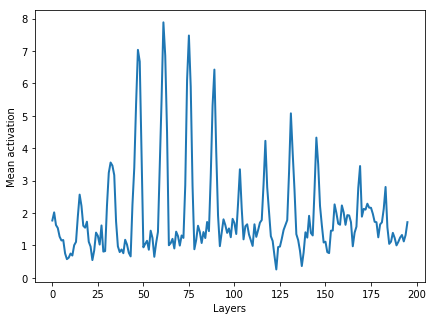

In [7]:
max_features = plot_features(feature_map, 2)

#### Visualize feture map

In [8]:
def show_feature_map(img_path, max_features):

    img = Image.open(img_path)
    img = img.resize((224,224), Image.ANTIALIAS)
    
    alphs = np.zeros((196))
    for key, value in max_features.items():
        alphs[key] = value

    plt.figure(figsize=(9,9))
    plt.subplot(121)
    plt.gca().set_title('Original image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(122)
    plt.gca().set_title('Feature map')
    plt.imshow(img)
    alp_curr = alphs.reshape(14,14)
    alp_img = skimage.transform.pyramid_expand(alp_curr, upscale=16, sigma=20, multichannel=False)
    plt.imshow(alp_img, alpha=0.75)
    plt.axis('off')
    
    plt.savefig(img_path.split('.')[0]+'_feature_map.jpg')    

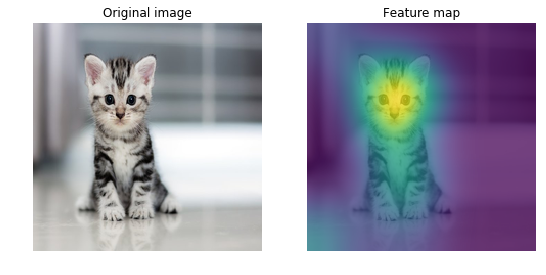

In [9]:
show_feature_map(img_path, max_features)

#### Let's try another image

In [25]:
layer = 42

model = models.vgg16_bn(True).cuda().eval()
model = list(model.children())[0]
activations = HookLayer(list(model.children())[layer])

img_path = 'images/face.jpg'
img = load_img(img_path)
out = model(img)

feature_map = [activations.features[0][:, x, y].max().item() for x in range(14) for y in range(14)]
activations.close()

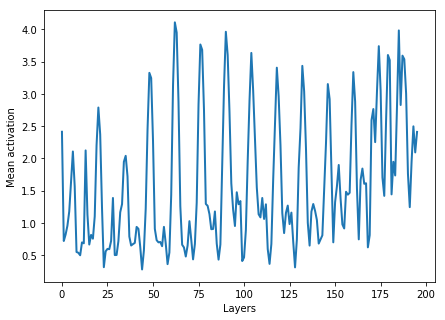

In [26]:
max_features = plot_features(feature_map, 3)

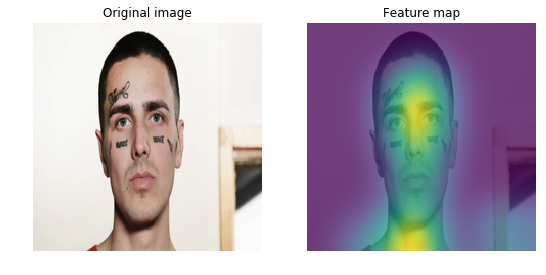

In [27]:
show_feature_map(img_path, max_features)

### Now let's try face recognition model from ArcFace to see how it detects faces

In [13]:
from model import Backbone

model = Backbone(50, 0.6, 'ir_se').cuda()
model.load_state_dict(torch.load('models/model_ir_se50.pth'))
model.eval()

model_cut = nn.Sequential(*list(model.children())[:-1])

In [14]:
model_cut

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=64)
  )
  (1): Sequential(
    (0): bottleneck_IR_SE(
      (shortcut_layer): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
      (res_layer): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): PReLU(num_parameters=64)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): SEModule(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (relu): 

In [15]:
list(list(list(list(model_cut.children())[-1].children())[-2].children())[-1].children())[-3]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [19]:
layer = -1

# hook = list(list(model_cut.children())[-1].children())[-1]
hook = list(list(list(list(model_cut.children())[-1].children())[-3].children())[-1].children())[-3]
activations = HookLayer(hook)

In [20]:
img_path = 'images/face.jpg'
img = load_img(img_path)
out = model_cut(img)

feature_map = [activations.features[0][:, x, y].max().item() for x in range(14) for y in range(14)]
activations.close()

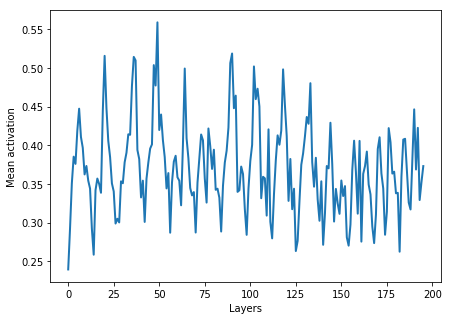

In [21]:
max_features = plot_features(feature_map, 0.5)

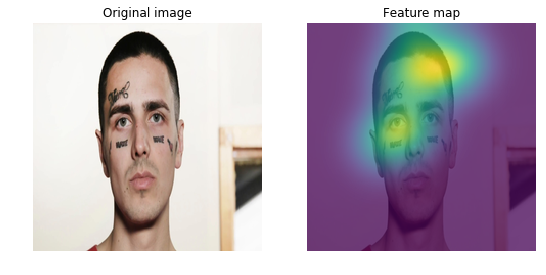

In [22]:
show_feature_map(img_path, max_features)